In [23]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy

In [317]:
# Class that holds a quantity which can be inflow, volume or outflow
class Quantity:
    
    def __init__(self, name=None, value=None, derivative=None):
        self.name = name
        
        if value == None:
            self.value = '0'
        else:
            self.value = value

        if derivative == None:
            self.derivative = '0'
        else:
            self.derivative = derivative
        
    def __repr__(self):
        string = '{}: ({}, {})'.format(self.name, self.value, self.derivative)
        if len(self.name) <= 6: 
            string = string[:6] + ' ' + string[6:]
            
        return string

    __str__ = __repr__
    
    def quantity_space(self):
        quantity_space = ['0', '+']
        if self.name != 'inflow':
            quantity_space.append('max')
        return quantity_space
    
    def quantity_change(self):        
        if self.derivative == '+':
            if len(self.quantity_space()) - 1 > self.quantity_space().index(self.value):
                self.value = self.quantity_space()[self.quantity_space().index(self.value) + 1]
            
        elif self.derivative == '-':
            if self.quantity_space().index(self.value) > 0:
                self.value = self.quantity_space()[self.quantity_space().index(self.value) - 1]   
        
        return quantity

# Class that holds a state
class State:

    def __init__(self, inflow=None, volume=None, outflow=None):
        if inflow == None:
            self.inflow = Quantity(name='inflow')
        else:
            self.inflow = inflow
            
        if volume == None:
            self.volume = Quantity(name='volume')
        else:
            self.volume = volume
            
        if outflow == None:
            self.outflow = Quantity(name='outflow')
        else:
            self.outflow = outflow
    
    def quantities(self):
        return [self.inflow, self.volume, self.outflow]
    
    def quantity_changes(self, quantity_name = None):
        state = copy.deepcopy(self)
        
        for quantity in state.quantities():
            if quantity_name == None or quantity_name == quantity.name:
                quantity.quantity_change()
    
        return state

    
    def __repr__(self):
        return  str(self.inflow) + '\n' + \
                str(self.volume) + '\n' + \
                str(self.outflow) + '\n'
        
    def description(self):
        quantities = [self.inflow, self.volume, self.outflow]
        
        for quantity in quantities:

            if quantity.value == '0':
                value = 'no'
            elif quantity.value == '+':
                value = 'some'
            elif quantity.value == 'max':
                value = 'a maximum amount of'
            
            if quantity.derivative == '0':
                derivative = 'remains the same'
            elif quantity.derivative == '+':
                derivative = 'is increasing'
            elif quantity.derivative == '-':
                derivative = 'is decreasing'
            
            print('There is {} {} and the {} {}.'.format(value, quantity.name, quantity.name, derivative))
            
    __str__ = __repr__
    

In [333]:
def get_children(node):
    prototypes = []
    
    # Rule 0: Derivative changes next state's values
    if not (node.volume.value == '+' and node.volume.derivative == '-' and node.inflow.value == '+'):
        prototypes.append(node.quantity_changes())
    
    if node.volume.value == '+' and node.volume.derivative != '0':
        prototypes.append(node.quantity_changes(quantity_name = 'inflow'))
        
   
    # Rule 1: Inflow derivative proportional to next state's volume and outflow derivative
    for prototype in prototypes:
        count = 0
        if prototype.inflow.value == '+':
            count += 1
        if node.inflow.derivative == '+':
            count += 1
        if prototype.outflow.value == '+' or prototype.outflow.value == 'max':
            count -= 1
            
        if count > 0:
            prototype.volume.derivative = '+'
            prototype.outflow.derivative = '+'
        elif count < 0:
            prototype.volume.derivative = '-'
            prototype.outflow.derivative = '-'
        else:
            prototype.volume.derivative = '0'
            prototype.outflow.derivative = '0'           

    # Rule 2: With maximum volume, the inflow has to be positive
    for prototype in prototypes:
        if prototype.volume.value == 'max':
            prototype.inflow.value = '+'
            
    # Rule 3: When max volume, the child's inflow has to be positive
    for prototype in prototypes:
        if node.volume.value == 'max':
            prototype.inflow.value = '+'
    
    # Rule 4: When max volume, the child's inflow has to be positive
    for prototype in prototypes:
        if node.inflow.value == '+' and prototype.volume.value == '0':
            prototype.inflow.value = '+'
    
    # Exceptions
    for prototype in prototypes:            
        if prototype.volume.value == 'max' and prototype.volume.derivative == '+':
            prototype.volume.derivative = '0'
            prototype.outflow.derivative = '0'
            
        if prototype.volume.value == '0' and prototype.volume.derivative == '-':
            prototype.volume.derivative = '0'
            prototype.outflow.derivative = '0'

        
    children = []
    
    for prototype in prototypes:
        
        if prototype.inflow.derivative == '0':
            child = copy.deepcopy(prototype)
            child.inflow.derivative = '0'
            children.append(child)
            
            child = copy.deepcopy(prototype)
            child.inflow.derivative = '+'
            children.append(child)
            
            if prototype.inflow.value != '0':
                child = copy.deepcopy(prototype)
                child.inflow.derivative = '-'
                children.append(child) 
                
        elif prototype.inflow.derivative == '+':
            child = copy.deepcopy(prototype)
            child.inflow.derivative = '0'
            children.append(child)
            
            child = copy.deepcopy(prototype)
            child.inflow.derivative = '+'
            children.append(child)
            
        elif prototype.inflow.derivative == '-':
            child = copy.deepcopy(prototype)
            child.inflow.derivative = '0'
            children.append(child)
            
            if prototype.inflow.value != '0':
                child = copy.deepcopy(prototype)
                child.inflow.derivative = '-'
                children.append(child) 
                
    return children

------------------------------------------
State 1
Current node:
inflow : (0, 0)
volume : (0, 0)
outflow: (0, 0)

There is no inflow and the inflow remains the same.
There is no volume and the volume remains the same.
There is no outflow and the outflow remains the same.
------------------------------------------
State 2
Current node:
inflow : (0, +)
volume : (0, 0)
outflow: (0, 0)

There is no inflow and the inflow is increasing.
There is no volume and the volume remains the same.
There is no outflow and the outflow remains the same.
------------------------------------------
State 3
Current node:
inflow : (+, 0)
volume : (0, +)
outflow: (0, +)

There is some inflow and the inflow remains the same.
There is no volume and the volume is increasing.
There is no outflow and the outflow is increasing.
------------------------------------------
State 4
Current node:
inflow : (+, +)
volume : (0, +)
outflow: (0, +)

There is some inflow and the inflow is increasing.
There is no volume and the

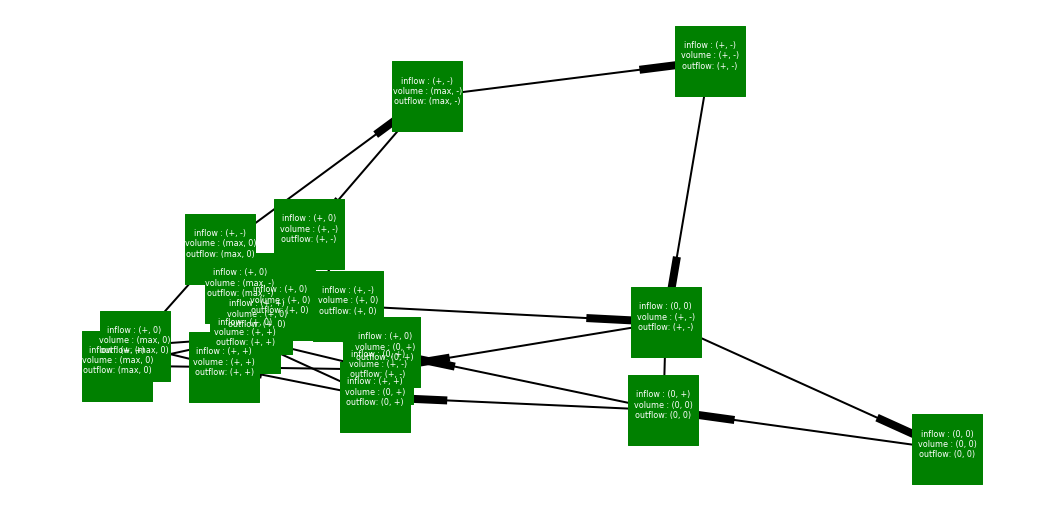

In [334]:
# The startnode is an empty tank with no inflow:
# inflow : (0, 0)
# volume : (0, 0)
# outflow: (0, 0)
startnode = State()

# The history is used to keep track of all the nodes we have seen before
history = [repr(startnode)]

# The stack keeps track of all the nodes we still have to explore
stack = [startnode]

G=nx.MultiDiGraph()
plt.figure(3,figsize=(18,9)) 
G.add_node(repr(startnode))

state_no = 0 # Counts the number of states

while len(stack) > 0 :
    
    print('------------------------------------------')
    
    state_no += 1
    print('State', state_no)
    
    # Get the an unexplored node and generate its children.
    node = stack.pop(0)
    
    # Some trace prints
    print('Current node:\n' + str(node))
    node.description()
    
    for child in get_children(node):
        # Add the edge to the graph between these two nodes   
        G.add_edge(repr(node), repr(child))
        if repr(child) not in history: # If child not seen before or not yet in stack
            stack.append(child) # Put in stack
            G.add_node(repr(child))
            history.append(repr(child))

# Draw graph
graph_pos=nx.spectral_layout(G, scale=1)
nx.draw_networkx_nodes(G,graph_pos,node_size=5000,alpha=1,node_color='green', node_shape='s')
nx.draw_networkx_edges(G,graph_pos,alpha=1,width=2, arrows=True)
nx.draw_networkx_labels(G,graph_pos,font_size=8, font_family='sans-serif', font_color='white')

# Show graph
plt.axis('off')
plt.show()